#### Relationship between store duration and revenue

##### 1. Get required data from the database by SQL query

In [1]:
import pyodbc
import pandas as pd

# Set the float number display format to 2 decimal places for readability
pd.set_option('display.float_format', '{:.2f}'.format)

# Create connection to the database
connection_string = ("Driver={SQL Server};"
            "Server=FUNGLAP\SERVER1;"
            "Database=AdventureWorks2019;"
            "Trusted_Connection=yes;")
connection = pyodbc.connect(connection_string)

# Get the opening year and the annual revenue of the stores by SQL query
year_revenue = pd.read_sql(
    """
SELECT
    [Demographics].value('declare default element namespace "http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey"; 
        (/StoreSurvey/YearOpened)[1]', 'integer') AS year_opened,
    [Demographics].value('declare default element namespace "http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/StoreSurvey"; 
        (/StoreSurvey/AnnualRevenue)[1]', 'money') AS annual_revenue 
FROM [Sales].[Store]
ORDER BY year_opened
    """, connection)

C:\Users\freef\AppData\Local\Temp\ipykernel_37624\3552719558.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  year_revenue = pd.read_sql(


In [2]:
# Examine the DataFrame `year_revenue`
print(year_revenue.head(),'\n')
print(year_revenue.info())

   year_opened  annual_revenue
0         1970        80000.00
1         1970        30000.00
2         1970        30000.00
3         1970        30000.00
4         1970        30000.00 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year_opened     701 non-null    int64  
 1   annual_revenue  701 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.1 KB
None


In [3]:
# Examine the DataFrame `year_revenue`
print(year_revenue.describe(),'\n')
print(year_revenue['annual_revenue'].value_counts())

       year_opened  annual_revenue
count       701.00          701.00
mean       1986.29       158473.61
std           9.13        98095.19
min        1970.00        30000.00
25%        1979.00        80000.00
50%        1987.00       150000.00
75%        1994.00       300000.00
max        2001.00       300000.00 

annual_revenue
300000.00    204
150000.00    192
80000.00     166
30000.00      87
100000.00     52
Name: count, dtype: int64


* As observed there are only 5 unique values for the `annual_revenue`

In [4]:
# Create a new column `duration` that represents the trading duration
import datetime
current_year = datetime.datetime.now().year
year_revenue['duration']=current_year-year_revenue['year_opened']

# Create a new column `annual_revenue_k` that shows the annual revenue as a multiple of 1000
year_revenue['annual_revenue_k']=year_revenue['annual_revenue'].apply(int)//1000

##### 2. Data visualisation

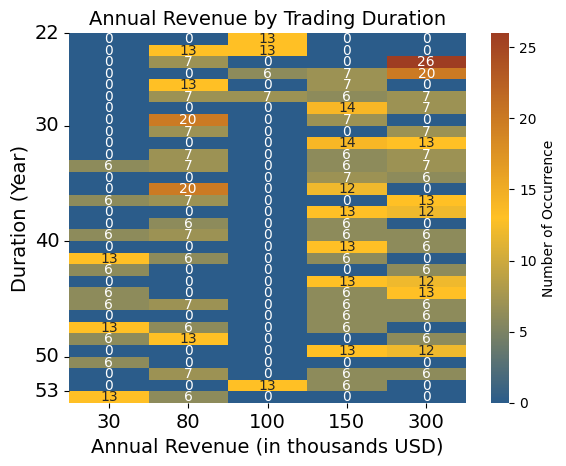

In [5]:
# Create a heatmap showing number of occurrence of different revenues and durations
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Pivot the `year_revenue` for creating the heatmap
pivot_data = year_revenue.drop(columns=['year_opened', 'annual_revenue'])
pivot_data = pivot_data.pivot_table(
    index='duration',
    columns='annual_revenue_k',
    aggfunc='value_counts').fillna(0)

# Create a custom colour map
cust_cmap = LinearSegmentedColormap.from_list(
    'custom_colormap',["#2b5c8a", "#FFC125", "#9e3d22"])

# Plot the heatmap
sns.heatmap(pivot_data, annot=True, cmap=cust_cmap,
    cbar=True,cbar_kws={'label': 'Number of Occurrence'})

# Customerize and show the plot
yticks_value = year_revenue['duration'].unique()
yticks_value.sort()
plt.xticks(fontsize=14)
plt.yticks(rotation=0, ticks=[0,8,18,28,31], labels=[22,30,40,50,53], fontsize=14)
plt.xlabel('Annual Revenue (in thousands USD)', fontsize=14)
plt.ylabel('Duration (Year)', fontsize=14)
plt.title('Annual Revenue by Trading Duration', fontsize=14)
plt.show()

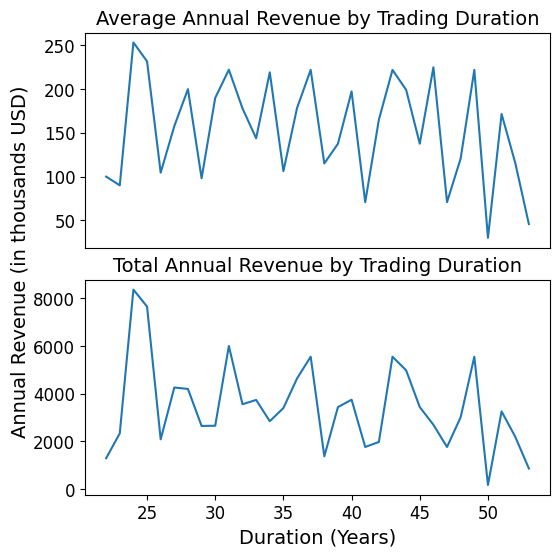

In [6]:
# Calculate the sum and the average of the revenues of each duration
grouped_revenue = year_revenue.groupby('duration')['annual_revenue_k'].mean()
sum_revenue = year_revenue.groupby('duration')['annual_revenue_k'].sum()

# Create a figure and two subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'hspace': 0.15})

# Plot the first subplot as a line plot and customerize it
axs[0].plot(grouped_revenue.index, grouped_revenue)
axs[0].set_xlabel('')
axs[0].set_xticks([])
axs[0].set_title('Average Annual Revenue by Trading Duration', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)

# Plot the second subplot as a line plot and customerize it
axs[1].plot(sum_revenue.index, sum_revenue)
axs[1].set_xlabel('Duration (Years)', fontsize=14)
axs[1].set_title('Total Annual Revenue by Trading Duration', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)

# Add a y-axis label to the whole figure
fig.text(0, 0.5, 'Annual Revenue (in thousands USD)', va='center',
    rotation='vertical', size=14)

# Show the figure
plt.show()

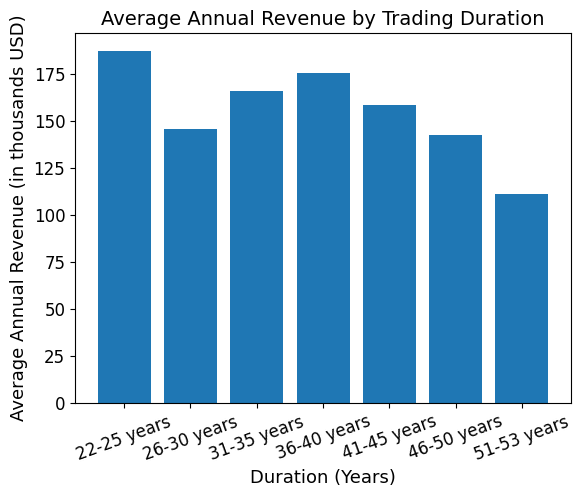

In [7]:
# Bin the durations into different ranges
bin_edges = [21, 25, 30, 35, 40, 45, 50, 55]
bin_labels = ['22-25 years', '26-30 years', '31-35 years', '36-40 years', '41-45 years', '46-50 years', '51-53 years']
year_revenue['duration_bins'] = pd.cut(year_revenue['duration'], bins=bin_edges, labels=bin_labels)

# Create a bar chart
bin_means = year_revenue.groupby('duration_bins')['annual_revenue_k'].mean()
plt.bar(bin_means.index, bin_means.values)

# Customerize and show the plot
plt.xlabel('Duration (Years)', fontsize=13)
plt.ylabel('Average Annual Revenue (in thousands USD)', fontsize=13)
plt.title('Average Annual Revenue by Trading Duration', fontsize=14)
plt.xticks(rotation=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [8]:
# Transform the type from series to DataFrame for next steps
grouped_revenue = grouped_revenue.reset_index()
sum_revenue = sum_revenue.reset_index()

In [9]:
# Create a function for showing the linear regression line and
#   the R-squared value on the graph
def reg_line(x, y, axs, plot_num, textx, texty):
    '''
    Draw linear regression line on the plot and show the R-squared values
    for linear or logarithmic scale on any of the axes
    '''
    # Create a scatter plot, show regression line and R-squared value
    from sklearn.linear_model import LinearRegression
    axs[plot_num].scatter(x, y, c='C0', s=90)
    reg = LinearRegression()
    reg.fit(x, y)
    yhat = reg.predict(x)
    axs[plot_num].plot(x, yhat, c='orange', alpha=0.6, lw=5)
    axs[plot_num].text(textx, texty, r'$R^2$ = {:.3f}'.format(reg.score(x,y)),
            transform=plt.gca().transAxes, color='orange', fontsize=15)

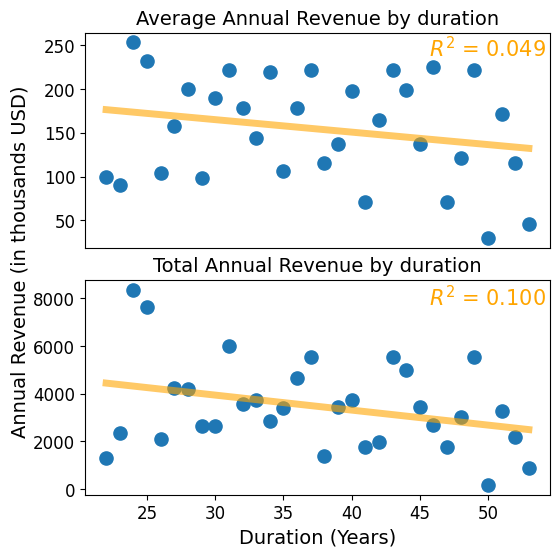

In [10]:
# Create a figure and two subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'hspace': 0.15})

# Plot the first subplot as a line plot, add regression lines and R-squared value
x = grouped_revenue[['duration']]
y = grouped_revenue[['annual_revenue_k']]
reg_line(x, y, axs, 0, 0.74, 2.04)

# Customerize the subplot
axs[0].set_xlabel('')
axs[0].set_xticks([])
axs[0].set_title('Average Annual Revenue by duration', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)

# Plot the second subplot as a line plot, add regression lines and R-squared value
x = sum_revenue[['duration']]
y = sum_revenue[['annual_revenue_k']]
reg_line(x, y, axs, 1, 0.74, 0.88)

# Customerize the subplot
axs[1].set_xlabel('Duration (Years)', fontsize=14)
axs[1].set_title('Total Annual Revenue by duration', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)

# Add a y-axis label to the whole figure
fig.text(0, 0.5, 'Annual Revenue (in thousands USD)', va='center',
    rotation='vertical', size=14)

# Show the figure
plt.show()

##### 3. Conclusion
* The data points have a strong sawtooth pattern where the annual revenue increase in a year and decrease in the next year, then increase in the following year
* There is not an observable linear trend when the store durations are binned into different ranges
* All the R-squared values of the scatter plots are close to zero indicating a low linear correlation between the variables
* It can be concluded that there is very slight to no linear correlation between the store duration and revenue